<a href="https://colab.research.google.com/github/Tieck-IT/Study/blob/main/tf_keras/practive_YOLOV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dhrim/darkeras-yolov4

Cloning into 'darkeras-yolov4'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 120 (delta 50), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (120/120), 5.57 MiB | 1.36 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
%cd darkeras-yolov4

/content/darkeras-yolov4


# 모델 파일 다운로드

In [3]:
!wget -O weights/yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2022-01-05 04:21:55--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘weights/yolov3.weights’

weights/yolov3.weig 100%[===================>] 236.52M   106MB/s    in 2.2s    

2022-01-05 04:21:57 (106 MB/s) - ‘weights/yolov3.weights’ saved [248007048/248007048]



In [4]:
!wget -O weights/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights


--2022-01-05 04:21:57--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘weights/yolov3-tiny.weights’

weights/yolov3-tiny 100%[===================>]  33.79M   102MB/s    in 0.3s    

2022-01-05 04:21:58 (102 MB/s) - ‘weights/yolov3-tiny.weights’ saved [35434956/35434956]



copy from https://github.com/tranleanh/darkeras-yolov4/blob/main/darkeras-yolov3.ipynb

# Import

In [5]:
import cv2
import numpy as np
import core.utils as utils
import core.common as common
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import colorsys
import random

print(tf.__version__)
print(tf.keras.__version__)

2.7.0
2.7.0


In [6]:
def darknet53(input_data):

    input_data = common.convolutional(input_data, (3, 3,  3,  32))
    input_data = common.convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = common.residual_block(input_data,  64,  32, 64)

    input_data = common.convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = common.residual_block(input_data, 128,  64, 128)

    input_data = common.convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = common.residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = common.convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = common.residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = common.convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = common.residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

In [7]:
def YOLOv3(input_layer):
    
    NUM_CLASS = 80
    
    route_1, route_2, conv = darknet53(input_layer)

    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))

    conv_lobj_branch = common.convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = common.convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1,  512,  256))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)

    conv = common.convolutional(conv, (1, 1, 768, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    conv_mobj_branch = common.convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = common.convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)

    conv = common.convolutional(conv, (1, 1, 384, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))

    conv_sobj_branch = common.convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = common.convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

In [8]:
def decode(conv_output, i=0):
    """
    return tensor of shape [batch_size, output_size, output_size, anchor_per_scale, 5 + num_classes]
            contains (x, y, w, h, score, probability)
    """

    NUM_CLASS = 80
    STRIDES = np.array([8, 16, 32])
    
    # anchors = np.array([10,13, 16,30, 33,23, 30,61, 62,45, 59,119, 116,90, 156,198, 373,326])
    anchors = np.array([1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875])
    ANCHORS = anchors.reshape(3, 3, 2)
    
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    conv_raw_prob = conv_output[:, :, :, :, 5: ]

    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

# 모델 생성

In [9]:
input_size   = 608
input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv3(input_layer)

feature_maps_array = np.array(feature_maps)

for fmap in feature_maps_array:
    print(fmap.shape)

(None, 76, 76, 255)
(None, 38, 38, 255)
(None, 19, 19, 255)


In [10]:
bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

In [11]:
# Load Weights
model = tf.keras.Model(input_layer, bbox_tensors)
utils.load_weights(model, "./weights/yolov3.weights")
# model.summary()

In [12]:
# If you want to save weights as h5 format
# model.save_weights("yolov4_waymo.h5")

# 이미지 로딩

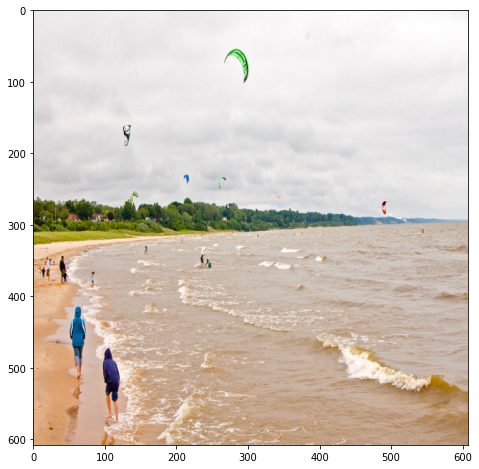

In [13]:
image_path = "./docs/kite.jpg"
original_image      = cv2.imread(image_path)
original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = cv2.resize(original_image, (input_size, input_size))
image_data = image_data/255.
image_data = image_data[np.newaxis, ...].astype(np.float32)

image_data_display = cv2.resize(original_image, (input_size,input_size))

plt.figure(figsize=(8,8))
plt.imshow(image_data_display)
plt.show()

In [14]:
pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)

In [15]:
pred_bbox_array = np.array(pred_bbox)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.05)
bboxes = utils.nms(bboxes, 0.45, method='nms')

(900, 1352, 3)


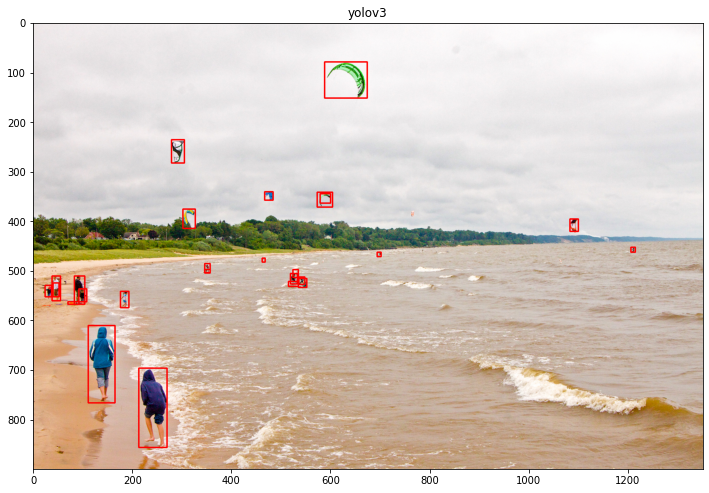

In [16]:
dummy = np.copy(original_image)
print(dummy.shape)

for box in bboxes:
    
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    conf = box[4]
    cls_id = int(box[5])
        
    dummy = cv2.rectangle(dummy, (x1,y1), (x2,y2), (255,0,0), 2)
     
plt.figure(figsize=(12,10))
plt.gca().set_title("yolov3"), plt.imshow(dummy)
plt.show()

# 박스 그리기

In [17]:
def draw_bbox(image, bboxes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    
    classes = utils.read_class_names("./data/classes/coco.names")

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

In [23]:
classes = utils.read_class_names("./data/classes/coco.names")
classes

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorbike',
 4: 'aeroplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'sofa',
 58: 'pottedplant',
 59: 'bed',
 60: 'diningtable',
 61: 'toilet',
 62: 'tvmonitor',
 63: 'laptop',
 64: 

In [18]:
image = draw_bbox(original_image, bboxes)

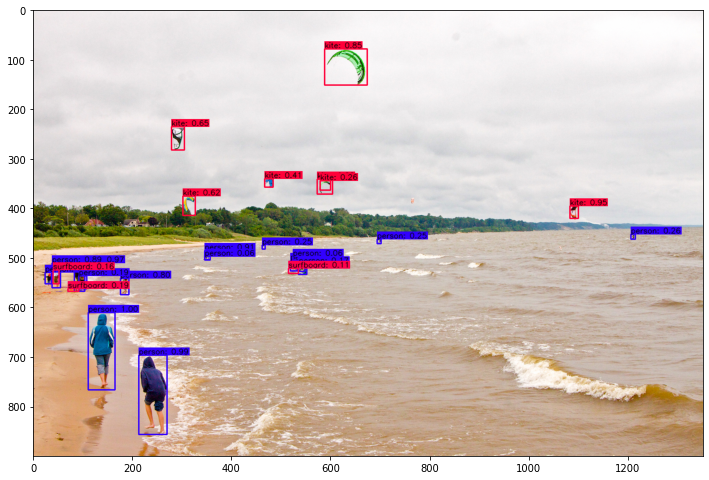

In [19]:
plt.figure(figsize=(12,10))
plt.imshow(image)
plt.show()

In [20]:
cv2.imwrite("detections_yolov3.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

True